## Note au jury — pricing de dérivés

Ce cahier regroupe des méthodes de valorisation (BSM, binomial, Monte Carlo) pour options. Les commentaires mettent l'accent sur les hypothèses et la comparaison des approches.


# Pricing d'options : BSM, CRR, Monte Carlo

Objectif : montrer comment différentes méthodes convergent (ou divergent) selon les paramètres de marché. On expose les formules analytiques, l'arbre binomial, et une simulation MC de base.


## Itinéraire

- Formule fermée BSM (call/put).
- Arbre de Cox-Ross-Rubinstein (CRR) : calibration p, u, d.
- Monte Carlo : trajectoires GBM, estimation du prix, erreur statistique.
- Comparaison : écarts, temps de calcul, sensibilité à sigma et T.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Vol Suface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

### Simulation

In this exercise, we assume the the sturcture of the vol surface. In practice, we would source the data from a data vendor.

We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Python Imports

In [35]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM

from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [36]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Defining functions and parameters

### True Parameters

In [37]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [38]:
risk_free_rate = 0.05

### Vol and Option Pricing Functions

In [39]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

<a id='1.3'></a>
## 2.3. Data Generation

In [40]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

### Set the Endog and Exog Data

In [41]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [42]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.142,1.236,0.862,0.292
1,0.054,1.052,0.179,0.218
2,0.126,1.198,0.733,0.277
3,0.097,1.346,0.799,0.292
4,0.131,1.046,0.496,0.250


In [43]:
pd.set_option('display.precision', 3)
dataset = pd.DataFrame(dataset)
print(dataset.describe())

           Price  Moneyness       Time        Vol
count  10000.000  10000.000  1.000e+04  10000.000
mean       0.175      1.004  4.963e-01      0.256
std        0.134      0.247  2.903e-01      0.030
min        0.000      0.051  1.040e-05      0.200
25%        0.071      0.837  2.420e-01      0.230
50%        0.157      1.001  4.949e-01      0.256
75%        0.250      1.174  7.503e-01      0.281
max        0.951      1.993  1.000e+00      0.385


<a id='2.2'></a>
## 3.2. Data Visualization

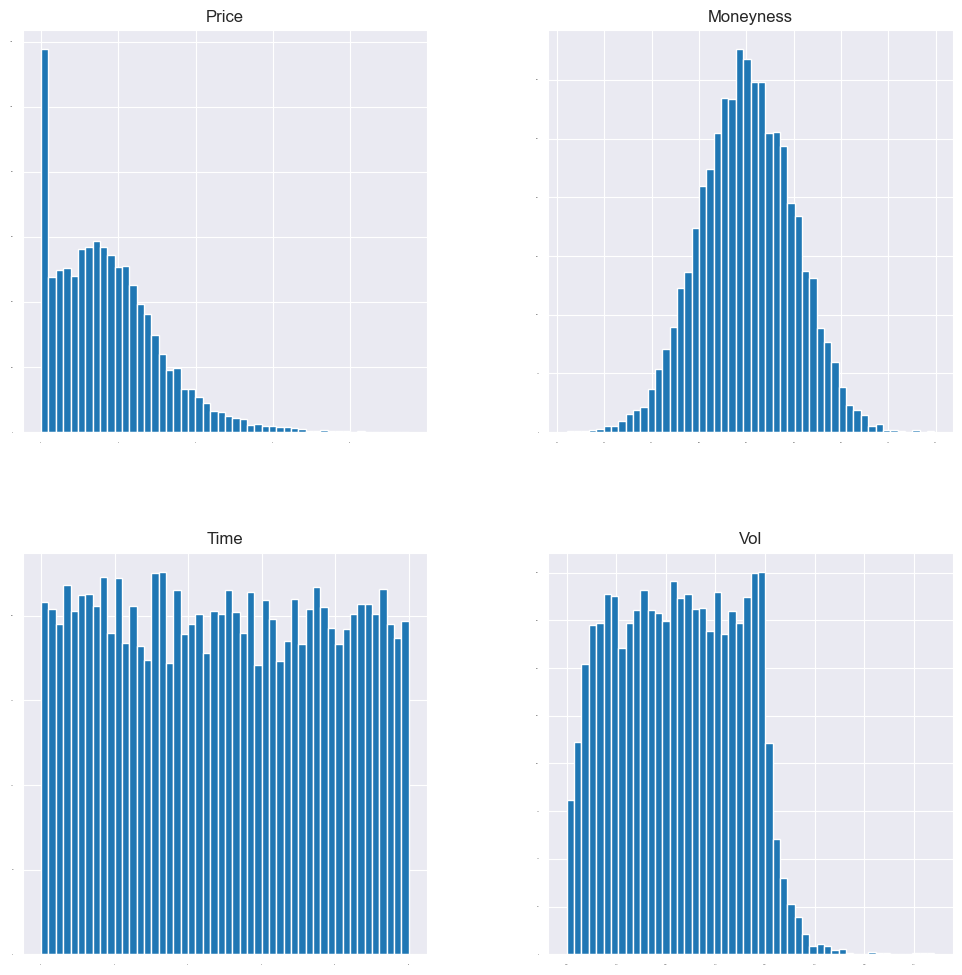

In [44]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

We can see that the price has an interesting distribution with a spike at $0$

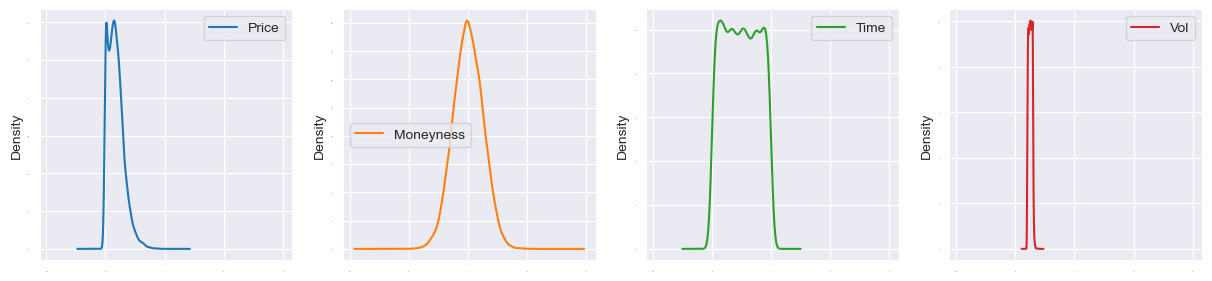

In [45]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Next we look at the interaction between different variables

<Axes: title={'center': 'Correlation Matrix'}>

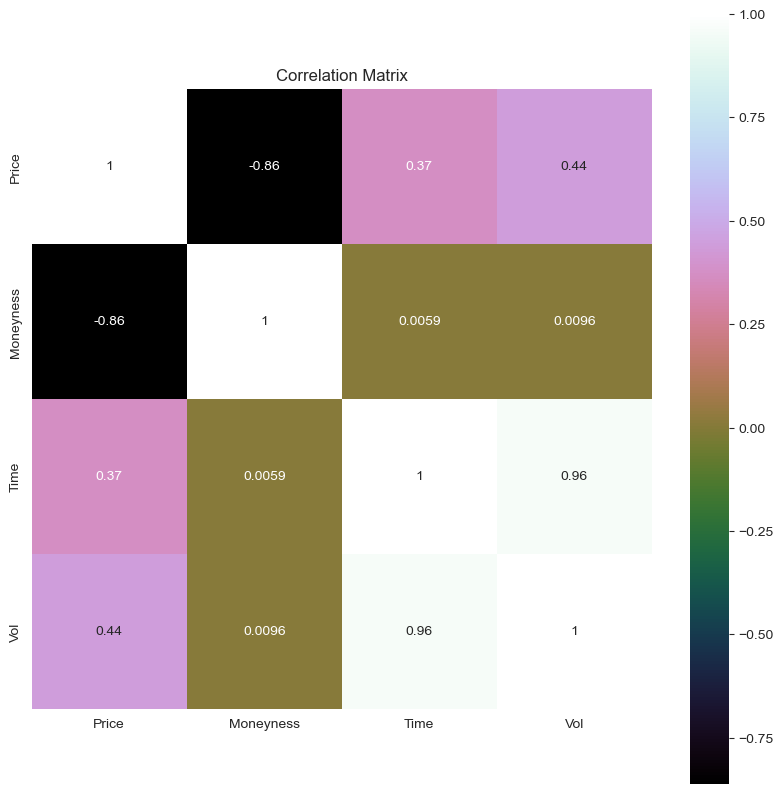

In [46]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

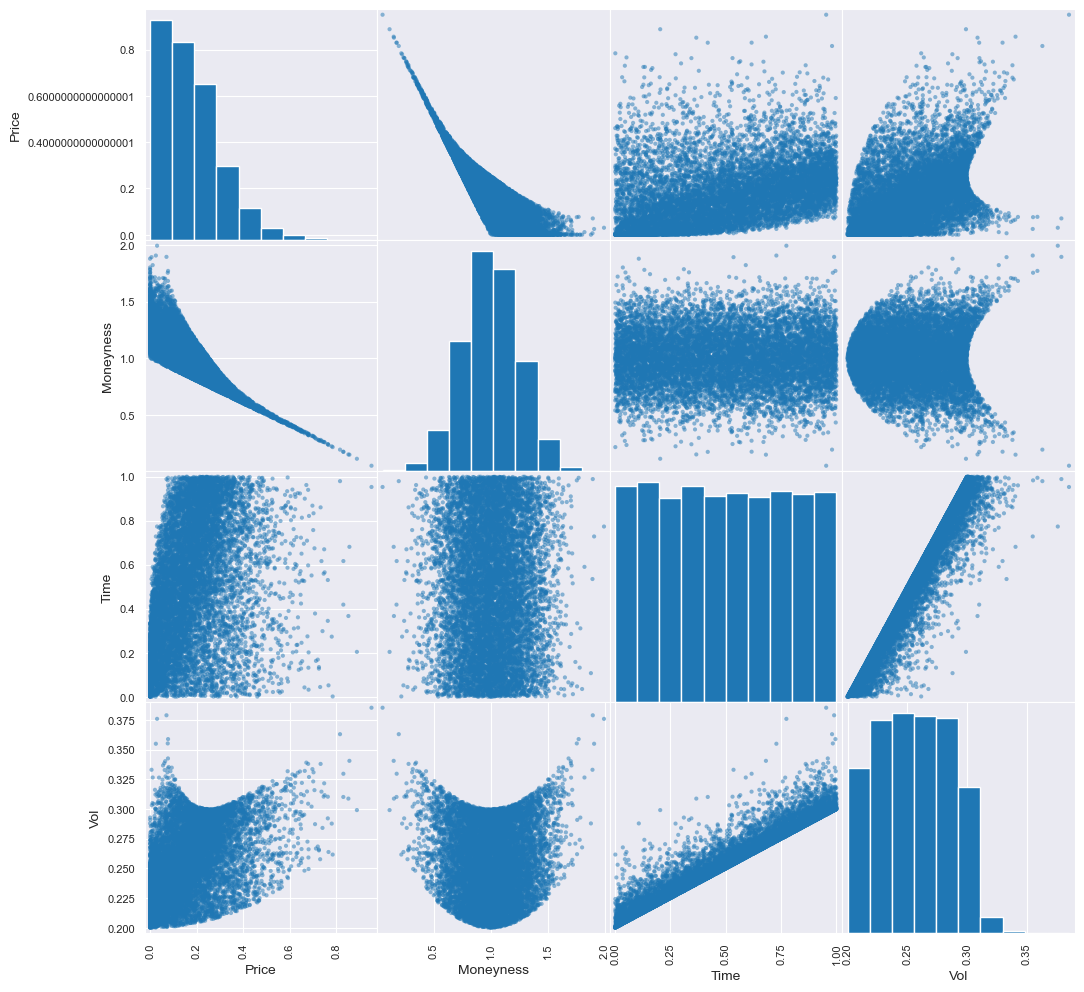

In [47]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

<a id='3'></a>
## 4. Data Preparation and Analysis

<a id='4.1'></a>
## 4.1. Univariate Feature Selection

We use SelectKBest function from sklearn

In [48]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,28899.433
Vol,2409.726
Time,1604.925


We observe that the moneyness is the most important variable for the price.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [49]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [50]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

#### Linear Models and Regression Trees

In [51]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#### Neural Network Predictor

In [52]:
models.append(('MLP', MLPRegressor()))

#### Boosting and Bagging Methods

In [53]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [54]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000355 (0.000027) 0.000354 0.000356
LASSO: 0.017902 (0.001116) 0.017892 0.017543
EN: 0.017902 (0.001116) 0.017892 0.017543
KNN: 0.000024 (0.000027) 0.000013 0.000010
CART: 0.000012 (0.000004) 0.000000 0.000009
SVR: 0.004572 (0.000085) 0.004592 0.004496
MLP: 0.000061 (0.000063) 0.000058 0.000060
ABR: 0.000713 (0.000045) 0.000729 0.000767
GBR: 0.000023 (0.000006) 0.000018 0.000021
RFR: 0.000005 (0.000008) 0.000000 0.000001
ETR: 0.000003 (0.000007) 0.000000 0.000000


We being by looking at the Kfold analysis

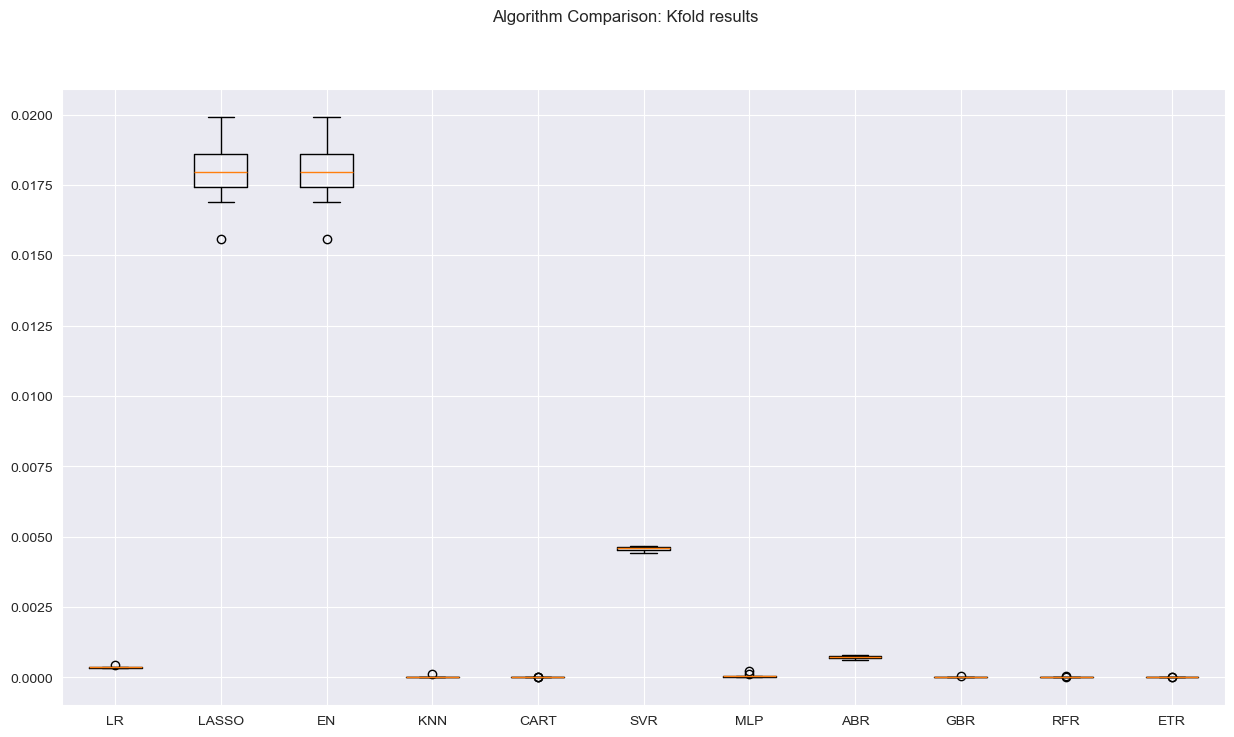

In [55]:

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

In order to get a better view, we remove the LASSO and Elastic Net

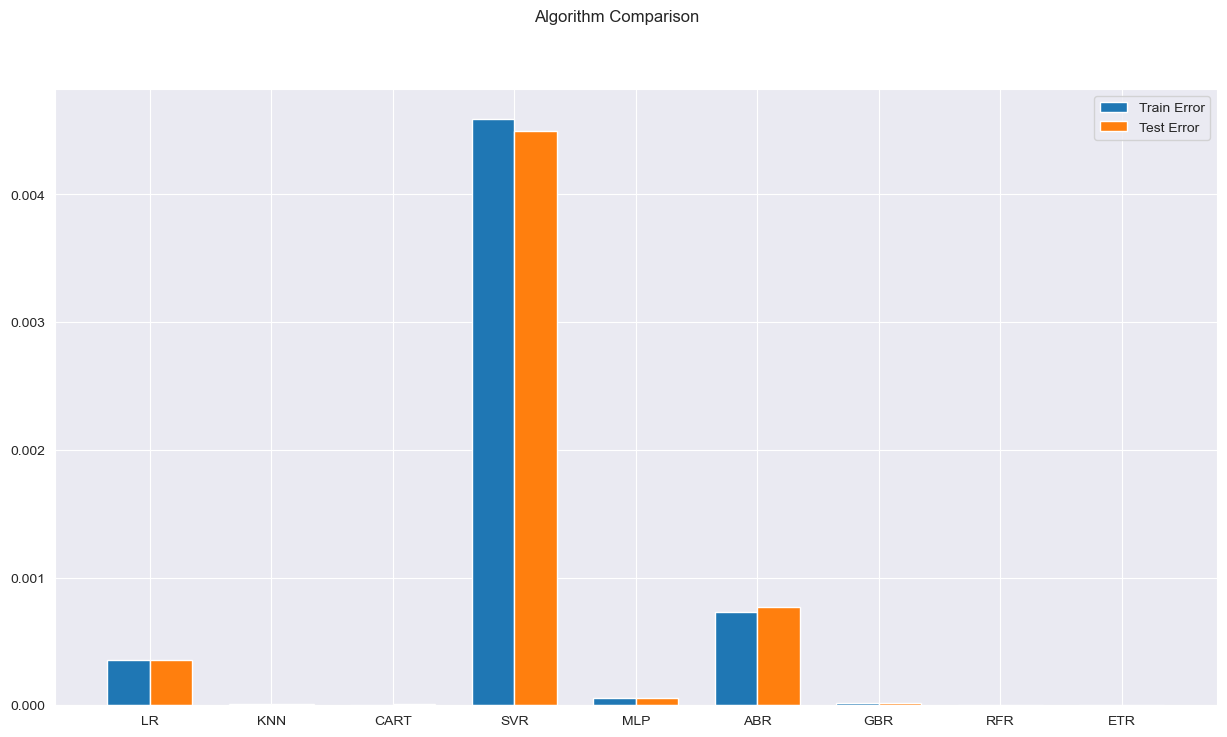

In [56]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Model Tuning and finalising the model

As shown in the chart above the MLP model is one of the best model, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.  

In [57]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

# Exemple de données (remplacez-les par les vôtres)
X = np.random.rand(100, 5)  # 100 échantillons, 5 features
y = np.random.randint(0, 2, 100)  # 100 labels (binaire)

# Définir un modèle et un hyperparamètre à tester
model = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100]}

# KFold (validation croisée avec 5 splits)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)

# Appel de la méthode fit()
grid_result.fit(X, y)

# Affichage des meilleurs résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

# Optionnel : Affichage des scores moyens et écarts-types
for mean, std, param in zip(means, stds, grid_result.cv_results_['params']):
    print("%f (%f) with: %r" % (mean, std, param))


Best: 0.460000 using {'n_estimators': 100}
0.440000 (0.101980) with: {'n_estimators': 10}
0.420000 (0.107703) with: {'n_estimators': 50}
0.460000 (0.073485) with: {'n_estimators': 100}


The best model is the model with 3 layers with 20, 30 and 20 nodes in each layer respectively. 

In [58]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [59]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

1.648066198980581e-05


We see that the mean error (RMSE) is  3.08e-5 , which is less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.

<a id='6'></a>
# 7. Additonal analysis: removing the volatilty data

Next, we make the process harder by trying to predict the price without the volatility data.

In [60]:
X = X[:, :2]

In [61]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [62]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [63]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [64]:
models.append(('MLP', MLPRegressor()))

In [65]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [66]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.014275 (0.010048) 0.013220 0.021806
KNN: 0.017204 (0.013530) 0.011094 0.021050
CART: 0.026804 (0.014747) 0.000000 0.031357
SVR: 0.017497 (0.011658) 0.011806 0.020623
MLP: 0.019996 (0.008271) 0.015622 0.016456
ABR: 0.018517 (0.016087) 0.007217 0.020024
GBR: 0.016933 (0.010468) 0.000875 0.028729
RFR: 0.015316 (0.011224) 0.002483 0.022780
ETR: 0.015083 (0.012152) 0.000000 0.025962


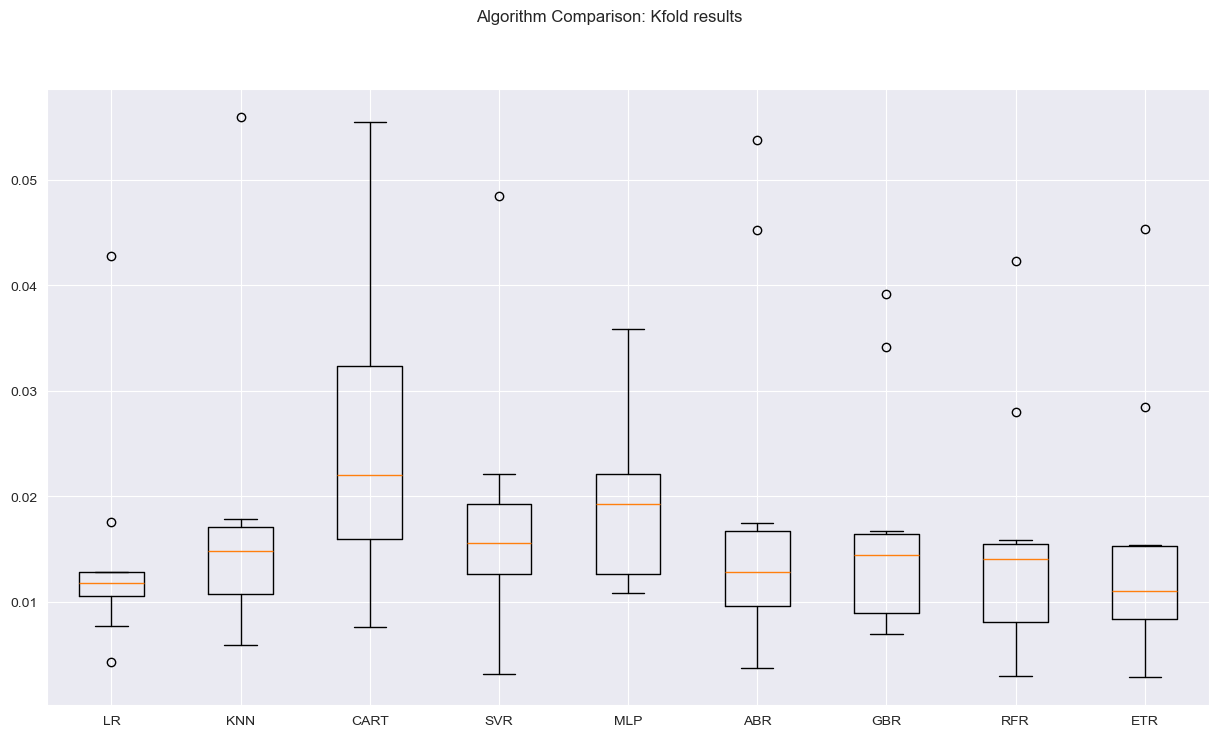

In [67]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

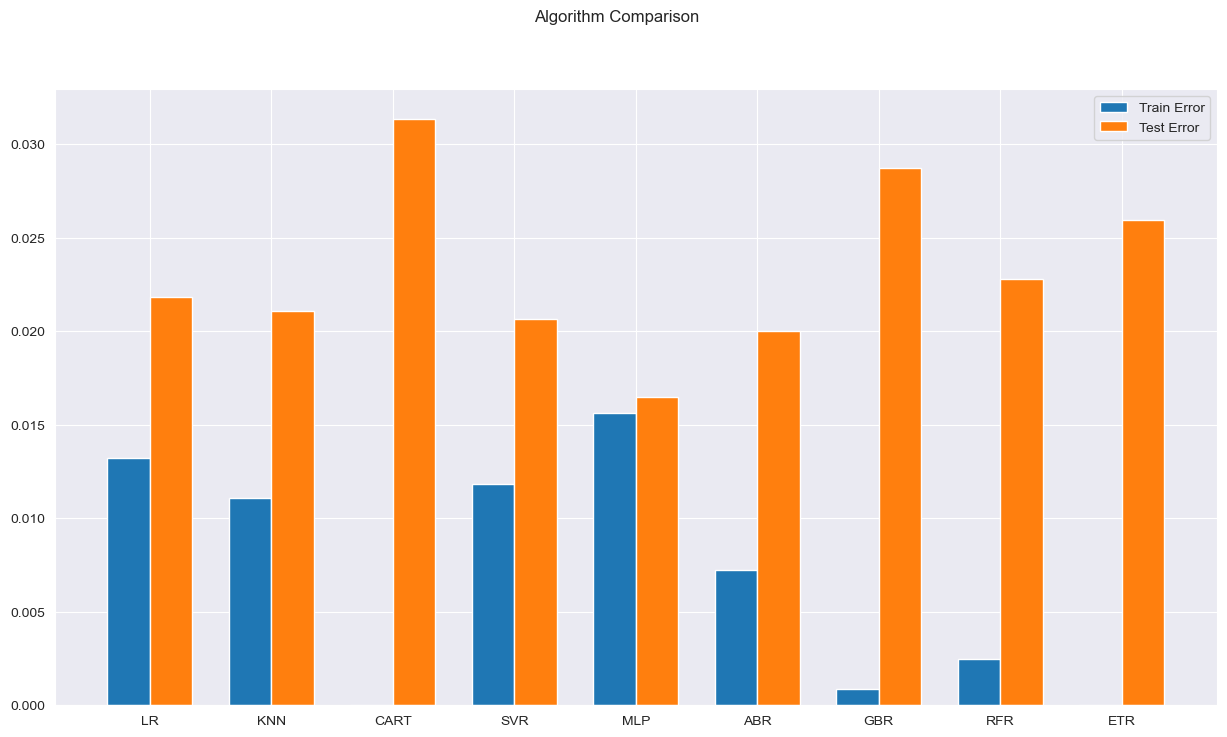

In [68]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

### Summary

## Conclusion

Les trois approches convergent dans le cadre BSM mais diffèrent en vitesse et flexibilité. Pour des payoffs exotiques, MC et arbres recombinants deviennent indispensables ; rester attentif au nombre de pas et à la variance de l'estimateur.
